In [1]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

# Download census-income dataset

* Target is binary, if income is >= 50K or not.
* Data source: https://archive.ics.uci.edu/ml/datasets/Census+Income

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# Load data and split

In [4]:
# column headers/feature names
feature_names = ["age", "workclass", "fnlwgt", 
                        "education", "education_num", 
                        "marital_status", "occupation",
                        "relationship", "race", "sex", 
                        "capital_gain", "capital_loss", 
                        "hours_per_week", "native_country", "income"]

In [5]:
train = pd.read_csv(out,header=None,names=feature_names)
target = "income" #' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [6]:
train.tail()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,Set
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,valid
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,train
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,train
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,train
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K,test


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [7]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

workclass 9
education 16
marital_status 7
occupation 15
relationship 6
race 5
sex 2
native_country 42
income 2
Set 3


# Define categorical features for categorical embeddings

In [8]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

# cat_dims = number of unique values in variable/column
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : A good heuristic is half the # of unique values, up to a maximum of 50. Here our variables have low cardinality. Note that `Set` isn't a feature
cat_emb_dim = [min(v//2+1,50) for v in categorical_dims.values()][:-2] # last 2 variables are target and Set indicator
# print("categoricals embeddings dimensions:",cat_emb_dim) ## [5, 9, 4, 8, 4, 3, 2, 22]

# Network parameters

In [9]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

Device used : cuda


# Training

In [10]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

In [11]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [12]:
clf.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
) 

Will train until validation stopping metric hasn't improved in 50 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | -0.31946 |  -0.17994 |   4.8       
| 2     | -0.15280 |  -0.32955 |   8.4       
| 3     | -0.13622 |  -0.26676 |   12.1      
| 4     | -0.13178 |  -0.22621 |   15.7      
| 5     | -0.12743 |  -0.20013 |   19.3      
| 6     | -0.12709 |  -0.15417 |   22.8      
| 7     | -0.12471 |  -0.12461 |   26.4      
| 8     | -0.12268 |  -0.12380 |   29.9      
| 9     | -0.12287 |  -0.12278 |   33.5      
| 10    | -0.12107 |  -0.12182 |   37.2      
| 11    | -0.11992 |  -0.11989 |   41.2      
| 12    | -0.11934 |  -0.11802 |   45.0      
| 13    | -0.11818 |  -0.11708 |   48.7      
| 14    | -0.11712 |  -0.11724 |   52.5      
| 15    | -0.11562 |  -0.11608 |   56.2      
| 16    | -0.11361 |  -0.11428 |   59.8      
| 17    | -0.11349 |  -0.11216 |   63.4      
| 18    | -0.11163 |  -0.11118 |   67.0      
| 19    | -0

In [13]:
# Best model is automatically loaded at end of fit
preds = clf.predict(X_test)

test_score = mean_squared_error(y_pred=preds, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost:.6}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_score:.6}")

BEST VALID SCORE FOR census-income : 0.0996807
FINAL TEST SCORE FOR census-income : 0.100988


# Global explainability : feat importance summing to 1

In [14]:
clf.feature_importances_

array([3.25987229e-06, 5.63586695e-03, 1.21311484e-03, 1.26350003e-02,
       1.27364044e-01, 5.38086823e-02, 1.52821290e-01, 1.89732903e-01,
       2.07340671e-04, 7.46324999e-03, 2.67158208e-01, 1.47141967e-01,
       0.00000000e+00, 3.48150732e-02])

In [15]:
important_features = pd.Series(data=clf.feature_importances_,index=train.columns[:-2])
important_features.sort_values(ascending=False,inplace=True)

display(important_features.sort_values(ascending=False))

capital_gain      0.267158
relationship      0.189733
occupation        0.152821
capital_loss      0.147142
education_num     0.127364
marital_status    0.053809
native_country    0.034815
education         0.012635
sex               0.007463
workclass         0.005636
fnlwgt            0.001213
race              0.000207
age               0.000003
hours_per_week    0.000000
dtype: float64

# Local explainability and masks

In [16]:
explain_matrix, masks = clf.explain(X_test)

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline

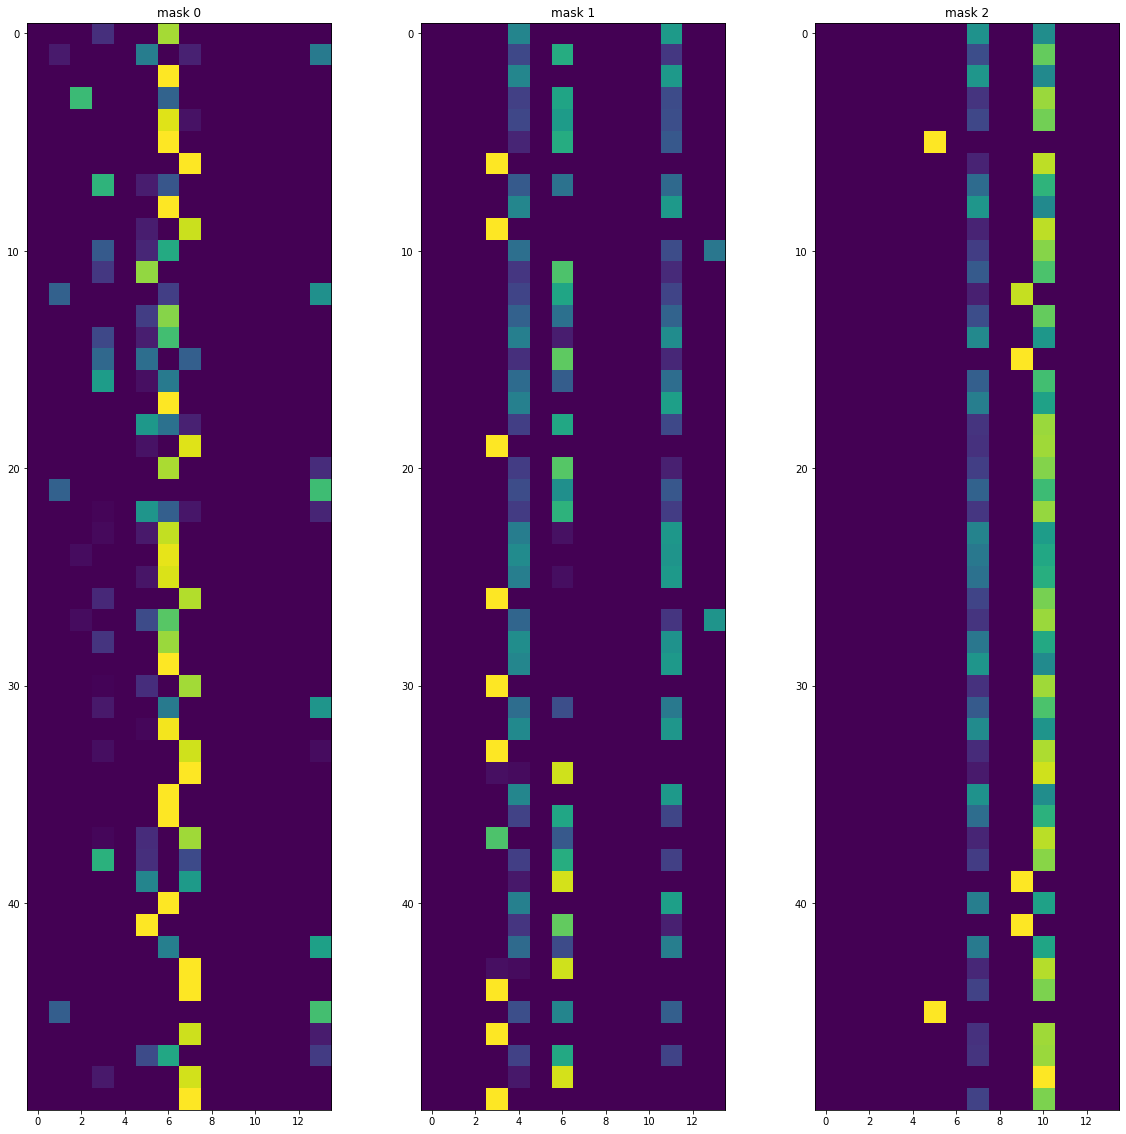

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [19]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-rmse:0.47080
Will train until validation_0-rmse hasn't improved in 40 rounds.
[10]	validation_0-rmse:0.33410
[20]	validation_0-rmse:0.30905
[30]	validation_0-rmse:0.30451
[40]	validation_0-rmse:0.30464
[50]	validation_0-rmse:0.30487
[60]	validation_0-rmse:0.30534
[70]	validation_0-rmse:0.30523
Stopping. Best iteration:
[34]	validation_0-rmse:0.30411



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=0, silent=None, subsample=0.7,
             tree_method=None, validate_parameters=False, verbosity=0)

##### XGBoost model results evaluation

In [20]:
preds = np.array(clf_xgb.predict(X_valid))
valid_mse = mean_squared_error(y_pred=preds, y_true=y_valid)
print(round(valid_mse,5))

preds = np.array(clf_xgb.predict(X_test))
test_mse = mean_squared_error(y_pred=preds, y_true=y_test)
print(round(test_mse,5))

0.09248
0.09244
